# Problem Set 3: Extra problems
## Learning from data [TIF285], Chalmers, Fall 2019

Last revised: 11-Oct-2019 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This problem set is performed individually (but collaboration is encouraged) and contains a number of basic and extra problems; you can choose which and how many to work on.
- See examination rules on the course web page.
- Hand-in is performed through the following **two** actions:
  - Upload of your solution in the form of a jupyter notebook, or python code, via Canvas.
  - Answer the corresponding questions on OpenTA.
  
  Note that the hand-in is not complete, and will not be graded, if any of those actions is not performed.

Fill your personal details
- Name: **Holmin, Sebastian**
- Personnummer: **970602-3679**
  <br/>
  (civic registration number)

## Problems
The 8 extra points of this problem set are distributed over two problems:
5. Bayesian Optimization (4 extra points)
6. Deep neural network python class (4 extra points)

# Problem 5: (extra) Bayesian Optimization
### (4 extra points)

In [61]:
# KEYS
#
%matplotlib inline
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import GPy
from scipy.optimize import minimize
# Not really needed, but nicer plots
import seaborn as sns
sns.set()
sns.set_context("talk")

### A univariate minimization problem

Try to minimize the function
$$
f(x) = \sin(6 x) + 0.2 x^2 - 0.7 x
$$
on the interval $x \in [-5,5]$.

The aim is to find the position of the minimum $x^*$ to within $\pm 0.05$ under the constraint that we would like to make as few function evaluations as possible.

### Task 1: Using "standard" optimization methods

a. **Plot the true function and indicate the position of the minimum**

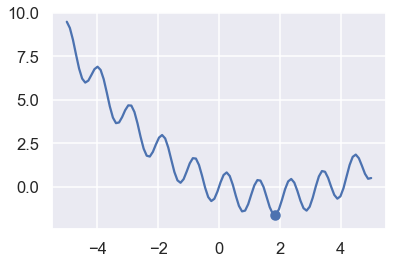

In [62]:
# Insert code here
#
def f(x):
    return np.sin(6*x)+0.2*x**2-0.7*x
x = np.linspace(-5,5,100)

#x0 = minimize(f,2).x[0]
x0 = 2*np.pi*(1+3/4)/6 #It's quite straight forward to solve it by hand too

plt.plot(x,f(x))
plt.scatter(x0,f(x0))

b. Find the minimum using `scipy.optimize.minimize` with `method='Nelder-Mead'`. 
* Choose the starting point randomly from a uniform pdf $U(-5,5)$. 
* Repeat one hundred times. **Do you always get the same minimum?**
* More specifically, set the tolerance of the optimizer to `tol=0.01` and check for success by the criterion $|x^* - x^*_\mathrm{opt}| < 0.05$, where $x^*_\mathrm{opt}$ is the result from the optimizer.
* Be quantitative about the average number of function evaluations that are needed per successful optimization. Compute the ratio of the total number of function evaluations number (summed over the 100 tries with different starting points) with the number of successful attempts.  
  *Hint*: The number of function evaluations from a `scipy.optimize.minimize` result is returned in the ``OptimizeResult`` object. 

Average amount of fun evals  114.58333333333333


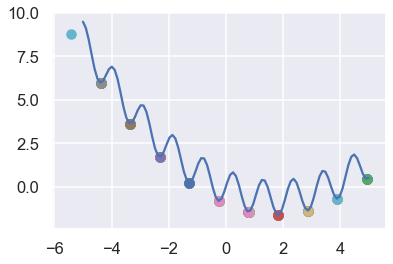

In [64]:
# Insert code here
#
plt.plot(x,f(x))
np.random.seed(0)

fun_evals = 0 # Total function evaluations
hits = 0 # Times correctly located minimum
for i in range(100):
    opt = minimize(f,np.random.uniform(-5,5),method='Nelder-Mead',tol=0.01)
    xopt = opt.x
    plt.scatter(xopt,f(xopt))
    hits += (np.abs(xopt-x0) < 0.05)
    fun_evals += opt.nfev
print('Average amount of fun evals ' , fun_evals/hits[0])

### Task 2. Build your own BayesOpt algorithm

You will now try a very different approach to minimize an objective function (this is a conventional name for the function that we are trying to minimize or maximize). The approach is known as **Bayesian optimization** and the basic idea is the following:
* Sample a few random points and build a **statistical model** for the unknown function (usually a Gaussian Process model).
* Make a decision which point to sample next based on a so called **acquisition function** evaluated from the statistical model. This will incorporate our current knowledge about the function including our uncertainty for its value in different regions.
* Improve the statistical model using the new sample. Continue sampling new points according to the acquisition function.
* If done correctly, this approach will balance **exploration** of new regions that might contain the minimum, and **exploitation** of searching the region that is currently most promising.
* Very importantly, this method also works when you are dealing with **noisy objective functions**, i.e. when your "measurement" of its value at a new point in parameter space contains some random noise.

Your task is to repeat the above minimization with **your own Bayesian Optimization algorithm**, that should be assembled as described below. Such algoritms are built into libraries such as `Scikit-optimize` and `GPyOpt`, but we will build our own simple version using functions from `numpy`, `scipy`, and `GPy` (for building the statistical model).

The pseudo-code for BayesOpt is the following (see specific hints for your implementation at the end):
1. pick starting points $\mathbf{x}^{(1)},\mathbf{x}^{(2)},\ldots \mathbf{x}^{(k)}$, where $k \geq 2$
1. evaluate the objective function $f(\mathbf{x})$ to obtain $y^{(i)}=f(\mathbf{x}^{(i)})$ for $i=1,\ldots,k$
1. initialize a data vector $\mathcal{D}_k = \left\{(\mathbf{x}^{(i)},y^{(i)})\right\}_{i=1}^k$
1. select a statistical model for $f(\mathbf{x})$
1. **For** {$n=k+1,k+2,\ldots$}
   1.    select $\mathbf{x}^{(n)}$ by optimizing the acquisition function: $\mathbf{x}^{(n)} = \underset{\mathbf{x}}{\text{arg max}}\, \mathcal{A}(\mathbf{x}|\mathcal{D}_{n-1})$
   1.    evaluate the objective function to obtain $y^{(n)}=f(\mathbf{x}^{(n)})$
   1.    augment the data vector $\mathcal{D}_n = \left\{\mathcal{D}_{n-1} , (\mathbf{x}^{(n)},y^{(n)})\right\}$
   1.    update the statistical model for $f(\mathbf{x})$
1. **end for**

   Check for the minimum in the data vector that has been collected (note that it doesn't necessarily have to be the last sample).


**Hints:**
* You have to implement all steps in the above pseudo-code.
* You can try with $k=2$ starting points.
* For the statistical model you can use `GPyOpt`. Follow the examples from the lectures and the exercise notebook.
* Any knowledge about the objective function should be built into the covariance function. Let us assume that we dan't have much information and that we use a standard RBF kernel.
* It is recommended to constrain the RBF lengthscale so that it doesn't become unrealistic small. With the GPy model called `model`, such a constraint can be imposed using `model['rbf.lengthscale'].constrain_bounded(.1,10)`.
* Implement the so called Lower Confidence Bound (LCB) acquisition function for use in step 5A. Then, the acquisition function is simply: $\mathcal{A}(\boldsymbol{x}; | \mathcal{D}_{n-1}) = -\mu(\boldsymbol{x}) + \beta \sigma(\boldsymbol{x})$, where
  * $\mu(\boldsymbol{x})$ is the mean of the GP model trained with the data $\mathcal{D}_{n-1})$.
  * $\sigma(\boldsymbol{x})$ is the standard deviation of the GP model trained with the data $\mathcal{D}_{n-1})$.
  * $\beta$ is another hyperparameter for tuning the preference for exploring unknown regions. You can set $\beta = 2$.
* Remember that the statistical model has to be updated (the hyperparameters re-optimized) at step 5D.

#### Tasks
* Implement the BayesOpt minimizer
* Assume that you are allowed a total of 100 function evaluations ($k$ of them for the starting points and $k-2$ in the loop). Are you abel to find the minimum to within $\pm 0.05$?
* Plot the final statistical model together with the true function and mark the minimum.
* Plot also the convergence of the minimum value $\min(y_n)$ as a function of the iteration number $n \in \{1, \ldots, 100\}$.

In [65]:
from GPyOpt.methods import BayesianOptimization
import GPy

k = 2
# I fiddled with beta and the kernel variance a lot to find stable values, nothing was very consistent but this worked ok for most random seeds.
beta = 10 # Increased beta to get a better spread of evals to capture the sin behaviour
np.random.seed(0)
x = np.array(np.random.uniform(-5,5,k)).reshape((-1,1))
y = f(x)

kernel = GPy.kern.RBF(input_dim=1, variance=5)
m = GPy.models.GPRegression(x,y,kernel)
m['rbf.lengthscale'].constrain_bounded(.1,10)
m.optimize(messages=False)

for i in range(98):
    Xp = np.linspace(-5,5,np.random.uniform(10,80))[:,None] #Some randimization to prevent the same points to be evaluated multiple times
    #Xp = np.random.uniform(-5,5,10)[:,None] #this version works too in most cases, but is less fool proof
    np.random.uniform(20,30)
    mu, C = m.predict(Xp)
    
    xnew = Xp[np.argmax(-mu+beta*np.sqrt(C))]
    ynew = f(xnew)
    x = np.append(x,xnew).reshape((-1,1))
    y = np.append(y,ynew).reshape((-1,1))
    m = GPy.models.GPRegression(x,y,kernel)
    m.optimize(messages=False)    

reconstraining parameters GP_regression.rbf.lengthscale


1.8181818181818183 is withing 0.05? of 1.83259
True


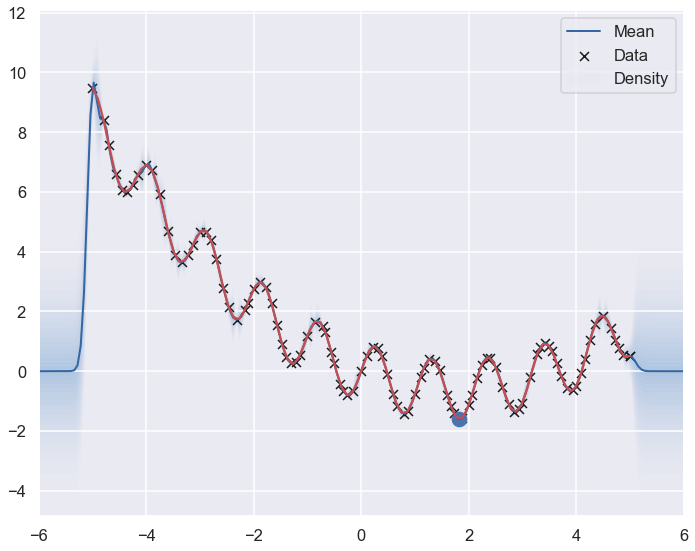

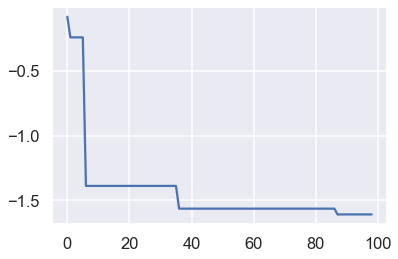

In [66]:
#plt.plot(Xp,mu)
m.plot(plot_limits=[-6,6],plot_density=True,figsize=(10,8))
i = np.argmin(y)
print(x[i][0], 'is withing 0.05? of 1.83259')
print(np.abs(x[i][0]-x0) < 0.05)
xtmp = np.linspace(-5,5,100)
plt.plot(xtmp,f(xtmp),'r',label='Real func')
plt.scatter(x[i],y[i],s=200)

ymin = [min(y[0:i]) for i in range(1,y.shape[0])]
plt.figure()
plt.plot(ymin)